# LSTM Stock Predictor Utilizing Closing Prices

In [134]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path
import yfinance as yf
from datetime import datetime, timedelta
%matplotlib inline

In [135]:
# Set the random seed for reproducibility
# Note: Used for model prototyping, but good practice to comment out and run multiple experiments to evaluate model.
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [136]:
# Set timeframe to pull data (365 * number of years)
lookback = 365 * 5
dt_end = datetime.now()
dt_start = datetime.now() - timedelta(days=lookback)
print(dt_end)
print(dt_start)

2020-09-16 10:19:02.531882
2015-09-18 10:19:02.531882


In [137]:
tickers = ['AAPL','IWM','ERII','EXG','EVT']

In [138]:
# Pull daily close information for tickers selected
df = pd.DataFrame()
df=yf.download(tickers,dt_start,dt_end)['Adj Close']
print(df.head(-1))

[*********************100%***********************]  5 of 5 completed
                  AAPL  ERII        EVT       EXG         IWM
Date                                                         
2015-09-18   26.210186  2.42  12.678830  5.343937  108.065796
2015-09-21   26.616798  2.43  12.608449  5.386621  107.869675
2015-09-22   26.198639  2.36  12.460985  5.290433  106.235428
2015-09-23   26.411180  2.31  12.414064  5.272396  105.917931
2015-09-24   26.568277  2.29  12.494498  5.182218  105.740501
...                ...   ...        ...       ...         ...
2020-09-09  117.320000  8.85  20.059999  7.720000  152.130005
2020-09-10  113.489998  8.80  19.750000  7.660000  150.149994
2020-09-11  112.000000  8.96  19.850000  7.680000  149.149994
2020-09-14  115.360001  8.65  20.100000  7.720000  153.080002
2020-09-15  115.540001  8.65  20.150000  7.770000  153.369995

[1257 rows x 5 columns]


In [139]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    Segments the data up with a rolling window of Xt - window to predict Xt.
    Returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [140]:
# Creating the features (X) and target (y) data using the window_data() function.
# Running for ERII (feature/target columns = 1)
window_size = 5

feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[2.42000008 2.43000007 2.3599999  2.30999994 2.28999996]
 [2.43000007 2.3599999  2.30999994 2.28999996 2.23000002]
 [2.3599999  2.30999994 2.28999996 2.23000002 2.16000009]
 [2.30999994 2.28999996 2.23000002 2.16000009 2.1099999 ]
 [2.28999996 2.23000002 2.16000009 2.1099999  2.1400001 ]] 

y sample values:
[[2.23000002]
 [2.16000009]
 [2.1099999 ]
 [2.1400001 ]
 [2.1400001 ]]


In [141]:
# 70% of the data for training and the 30% for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [142]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [143]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#print (f"X_train sample values:\n{X_train[:5]} \n")
#print (f"X_test sample values:\n{X_test[:5]}")

In [144]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [145]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [146]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [147]:
# Summarize the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_19 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_20 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [148]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
875/875 [==============================] - 2s 2ms/step - loss: 0.0158
Epoch 2/10
875/875 [==============================] - 2s 2ms/step - loss: 0.0128
Epoch 3/10
875/875 [==============================] - 2s 2ms/step - loss: 0.0112
Epoch 4/10
875/875 [==============================] - 2s 2ms/step - loss: 0.0100
Epoch 5/10
875/875 [==============================] - 2s 2ms/step - loss: 0.0089
Epoch 6/10
875/875 [==============================] - 2s 2ms/step - loss: 0.0080
Epoch 7/10
875/875 [==============================] - 2s 2ms/step - loss: 0.0060
Epoch 8/10
875/875 [==============================] - 2s 2ms/step - loss: 0.0074
Epoch 9/10
875/875 [==============================] - 2s 2ms/step - loss: 0.0068
Epoch 10/10
875/875 [==============================] - 2s 2ms/step - loss: 0.0061


In [149]:
# Evaluate the model
model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 1ms/step - loss: 0.0042


0.004239378031343222

In [150]:
# Make some predictions
predicted = model.predict(X_test)

In [151]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [152]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stocks.head()

,Actual,Predicted
0,8.96,8.562310
1,8.46,8.555796
2,8.44,8.523501
3,8.39,8.473953
4,8.40,8.436364


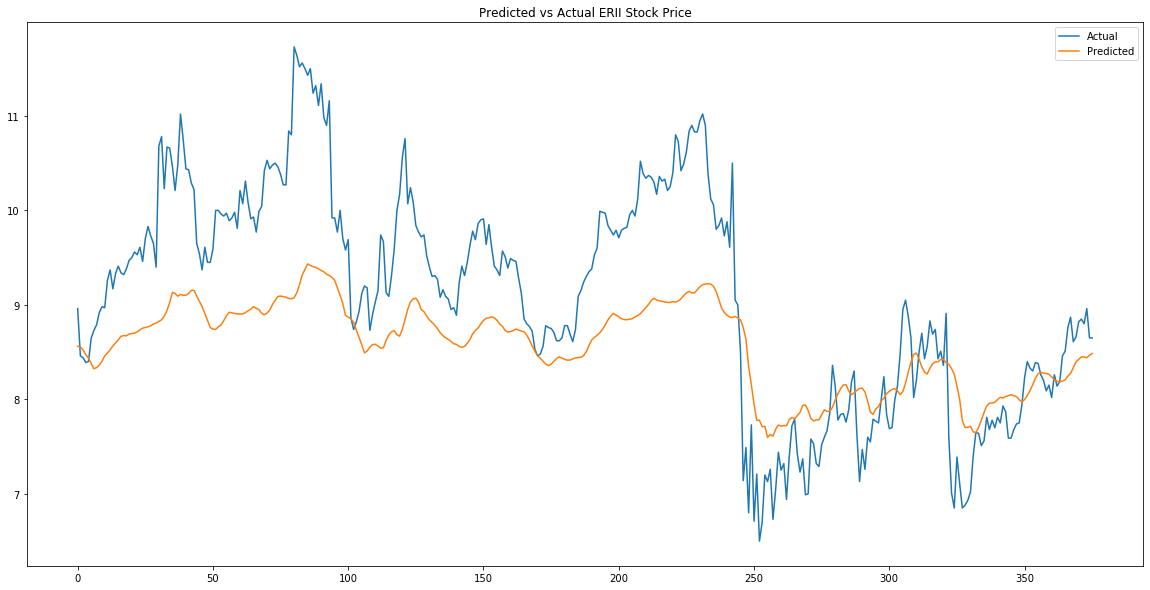

In [153]:
# Plot actual vs predicted prices as a line chart
stocks.plot(kind='line',figsize=(20,10),title='Predicted vs Actual ERII Stock Price');